Presentation theme: Your target audience is non-technical people interested in using your findings to maximize their profit when selling their home.

- figure out 3 - 4 questions:
    - what are the top 5 features that are the most important in determining house prices
    - how much in average is the difference in waterfront houses and non-waterfront houses
    - which zipcode attracts higher prices and vice versa
    - how have average house prices faired over time & what is the best time of year to sell
    
    
- clean data & feature engineering
    - duplicates: issues it could be sold multiple times
    - find missing values
    - find odd values (too high / negative values)
    - find outliers values (figure out what to do with them)
    - do we need to change datatype of any columns? to date? to int64
    - do we need to encode any categorical data?
    - any new variabes we can create or combine
    
- which columns to drop
    - id / yr_renovated
   
- visualization & basic stats
    - use correlation matrix (use np.triangle etc)
   
   
- linear regression - multiple
    - plot the coefficients in a graph
    - identify how adding each coefficient improves the R2
    - pick out the highest coefficients and plot simple regression / use reg coef to identify deeper to above ques
    - use p value


- understand the output of statsmodel


Questions
* "How did you pick the question(s) that you did?"
* "Why are these questions important from a business perspective?"
* "How did you decide on the data cleaning options you performed?"
* "Why did you choose a given method or library?"
* "Why did you select those visualizations and what did you learn from each of them?"
* "Why did you pick those features as predictors?"
* "How would you interpret the results?"
* "How confident are you in the predictive quality of the results?"
* "What are some of the things that could cause the results to be wrong?"

Data Issues Encountered:

Duplicate Data
    - id

Missing Data
    - waterfront 
    - view 
    - yr_renovated

Outliers
    - sqft_living
    - sqft_lot
    - sqft_lot15
    - bedroom
    
Adding New Columns

Incorrect data type
    - sqft_basement: treated as text as oppose to int64 / float64 due to '?'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.2f}'.format

# Import the data and parse the 'date' column as the second argument to convert the column dtype from str to datetime

In [2]:
url = 'https://raw.githubusercontent.com/Ftan91/Project-1---Kings-County-House-Dataset/master/kc_house_data.csv'
df = pd.read_csv(url, parse_dates = ['date'])

Check the first 5 rows of the dataframe and get the general information of the dataframe

In [3]:
display (df.head())
df.info()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,...,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,2014-12-09,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,...,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639
2,5631500400,2015-02-25,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,...,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,2014-12-09,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,...,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2015-02-18,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,...,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

Check and drop for duplicates

In [4]:
df = df.drop_duplicates(subset = 'id')
print ('Number of rows before: 21597')
print ('Number of rows after dropping duplicates: {}'.format(df.shape[0]))
print ('Total number of rows dropped: {}'.format(21597 - df.shape[0]))

Number of rows before: 21597
Number of rows after dropping duplicates: 21420
Total number of rows dropped: 177


In [5]:
# define function to return number of unique data types and the list of data types for a single column
def datatype_search(column):
    x = df[column].unique()
    y = set([type(number) for number in x])
    z = len(y)
    return list(y), z

# define function to return a random number based on given list of choice, added with probability
def function(column):
    if column == 'sqft_basement':
        basement_unique = df[df['sqft_basement'] != '?']['sqft_basement'].unique()
        basement_prob = df[df['sqft_basement'] != '?']['sqft_basement'].value_counts(normalize = True)
        return np.random.choice(basement_unique, 1, p= basement_prob)[0]
    else:
        unique = df[df[column].notnull()][column].unique()
        prob = df[df[column].notnull()][column].value_counts(normalize = True)
        return np.random.choice(unique, 1, p= prob)[0]

Print general description of each column including missing values, number of data entries for each column, negati

In [6]:
# check for missing values, multiple data entries for each column, negative values and 
isnull = df.isnull().sum().sort_values(ascending = False)

for column in isnull.index:
    print ('Column name: {}'.format(column))
    print ('Number of null entries: {}'.format(df[column].isnull().sum()))
    print ('Number of unique datatype: {}'.format(datatype_search(column)[1]))
    print ('Data entry type: {}'.format(datatype_search(column)[0]))
    print ('Min: {}, Max: {}'.format(df[column].min(), df[column].max()))
    print ('\n')

Column name: yr_renovated
Number of null entries: 3804
Number of unique datatype: 1
Data entry type: [<class 'numpy.float64'>]
Min: 0.0, Max: 2015.0


Column name: waterfront
Number of null entries: 2353
Number of unique datatype: 1
Data entry type: [<class 'numpy.float64'>]
Min: 0.0, Max: 1.0


Column name: view
Number of null entries: 63
Number of unique datatype: 1
Data entry type: [<class 'numpy.float64'>]
Min: 0.0, Max: 4.0


Column name: sqft_lot15
Number of null entries: 0
Number of unique datatype: 1
Data entry type: [<class 'numpy.int64'>]
Min: 651, Max: 871200


Column name: date
Number of null entries: 0
Number of unique datatype: 1
Data entry type: [<class 'numpy.datetime64'>]
Min: 2014-05-02 00:00:00, Max: 2015-05-27 00:00:00


Column name: price
Number of null entries: 0
Number of unique datatype: 1
Data entry type: [<class 'numpy.float64'>]
Min: 78000.0, Max: 7700000.0


Column name: bedrooms
Number of null entries: 0
Number of unique datatype: 1
Data entry type: [<class

In [7]:
missing_values_column = ['yr_renovated', 'waterfront', 'view', 'sqft_basement']

for column in missing_values_column:
    df[column] = df[column].map(lambda x: function(column) if (pd.isnull(x) or x == '?') else x)

df['sqft_basement'] = df['sqft_basement'].map(lambda x: int(float(x)))
df['sqft_abv&below'] = df['sqft_above'] + df['sqft_basement']
df['sqft_lot&living'] = df['sqft_lot'] + df['sqft_living']
df['sqft_neighbor_total'] = df['sqft_lot15'] + df['sqft_living15']

columns_to_drop = ['id', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
df.drop(columns_to_drop, axis = 1, inplace = True)

In [8]:
df.drop(df[df.bedrooms > 20].index, axis = 0, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21419 entries, 0 to 21596
Data columns (total 17 columns):
date                   21419 non-null datetime64[ns]
price                  21419 non-null float64
bedrooms               21419 non-null int64
bathrooms              21419 non-null float64
floors                 21419 non-null float64
waterfront             21419 non-null float64
view                   21419 non-null float64
condition              21419 non-null int64
grade                  21419 non-null int64
yr_built               21419 non-null int64
yr_renovated           21419 non-null float64
zipcode                21419 non-null int64
lat                    21419 non-null float64
long                   21419 non-null float64
sqft_abv&below         21419 non-null int64
sqft_lot&living        21419 non-null int64
sqft_neighbor_total    21419 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(8)
memory usage: 2.9 MB


In [10]:
continuous_var = ['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_abv&below', 'sqft_lot&living', 'sqft_neighbor_total']
ordinal_var = ['condition', 'view', 'grade']
categorical_var = ['waterfront', 'view', 'zipcode']
date = ['date', 'year', 'month', 'day']

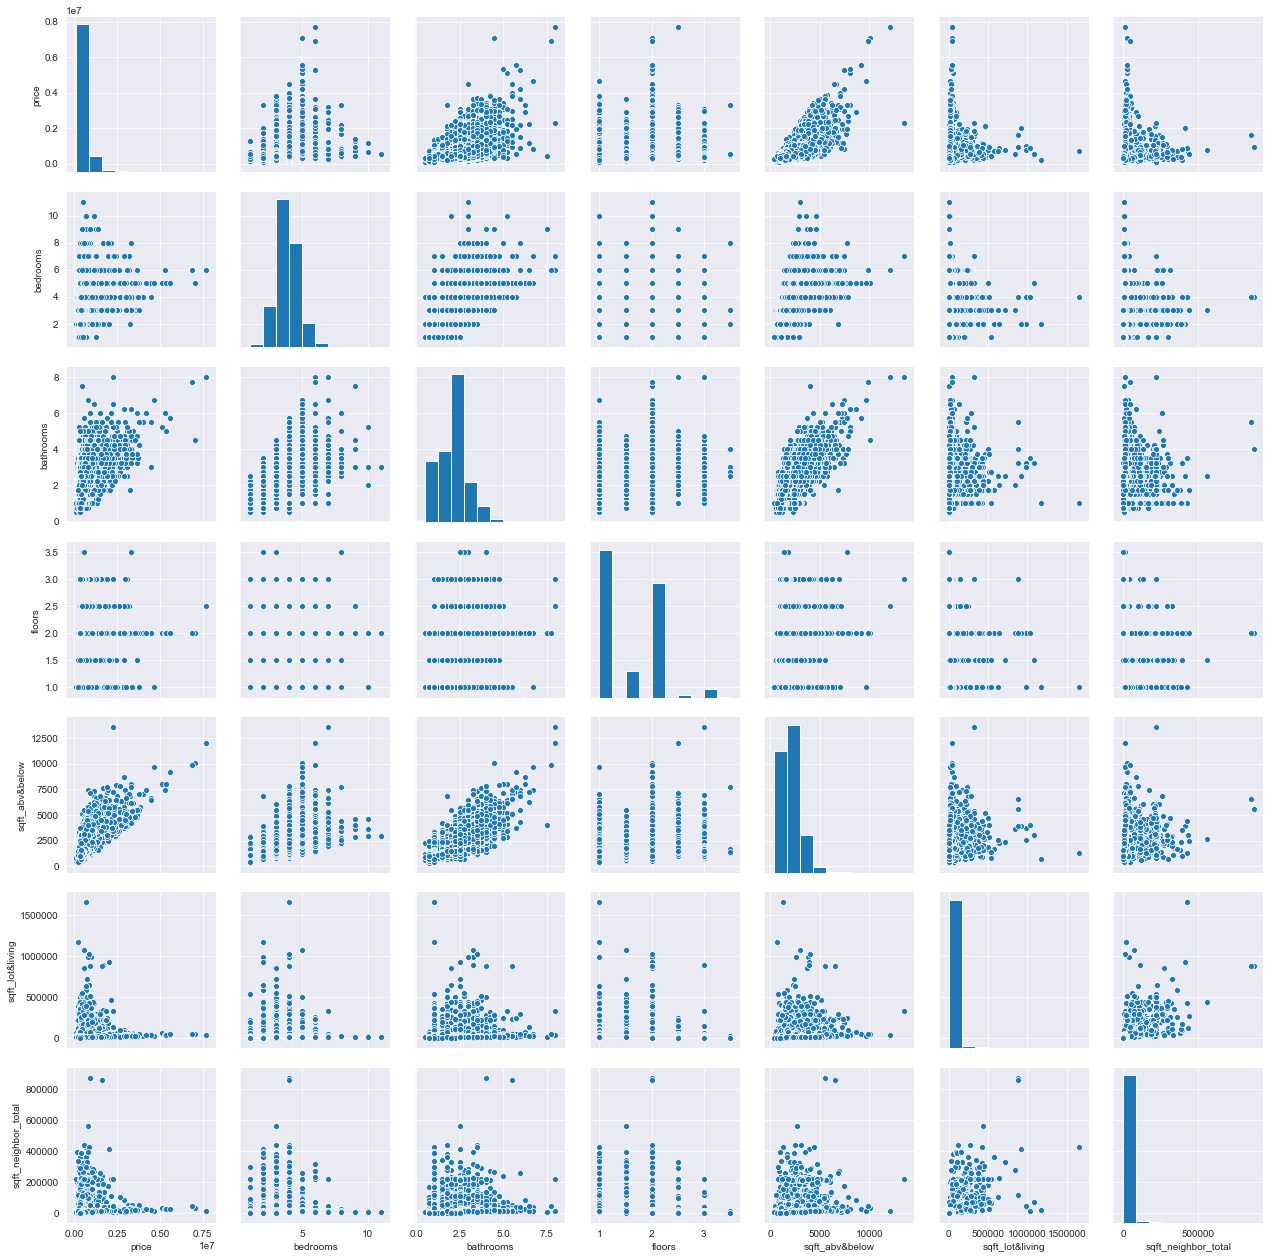

In [11]:
sns.pairplot(df[continuous_var])

/Users/weeliptan/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


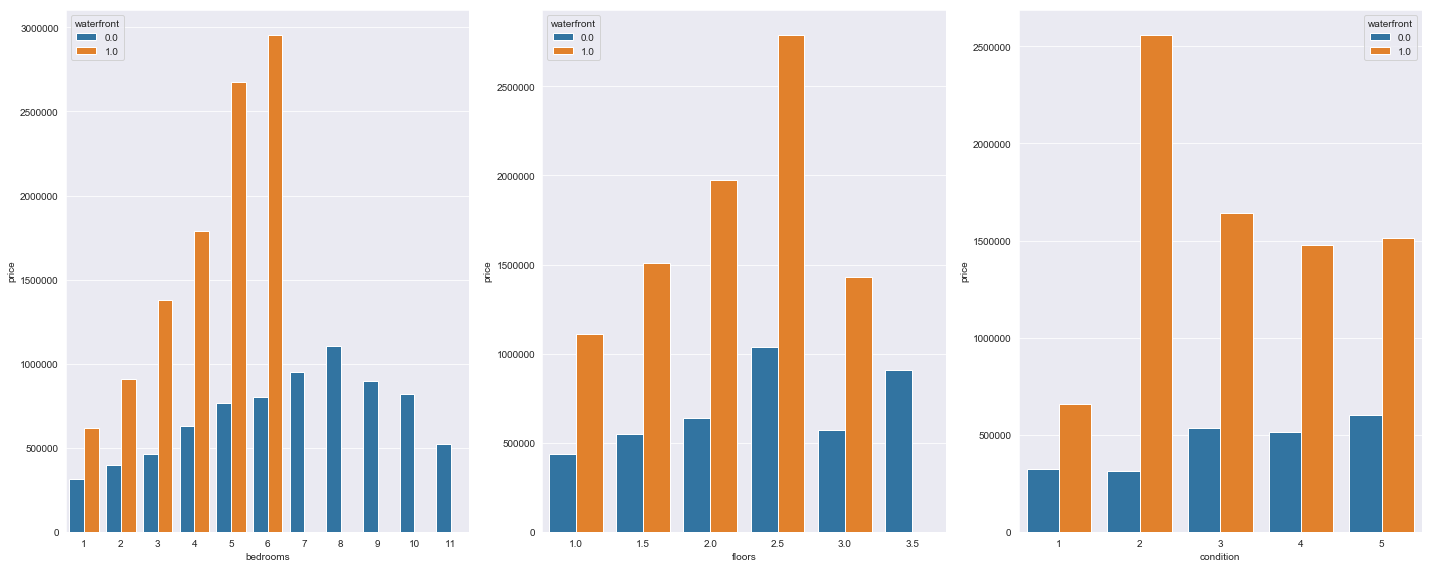

In [12]:
waterfront_bedrooms = df.groupby(['waterfront', 'bedrooms'])['price'].mean().reset_index()
waterfront_floor = df.groupby(['waterfront', 'floors'])['price'].mean().reset_index()
waterfront_condition = df.groupby(['waterfront', 'condition'])['price'].mean().reset_index()

f, axes = plt.subplots(1, 3, tight_layout = True, figsize = (20, 8))

sns.catplot(x = 'bedrooms', y = 'price', hue = 'waterfront', data = waterfront_bedrooms, kind = 'bar', ax = axes[0])
sns.catplot(x = 'floors', y = 'price', hue = 'waterfront', data = waterfront_floor, kind = 'bar', ax = axes[1])
sns.catplot(x = 'condition', y = 'price', hue = 'waterfront', data = waterfront_condition, kind = 'bar', ax = axes[2])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.show()

/Users/weeliptan/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


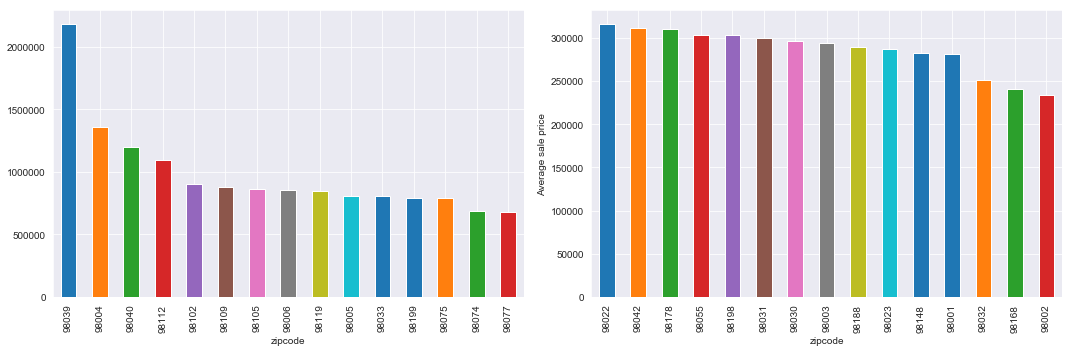

In [13]:
zipcode = df.groupby('zipcode')['price'].mean().sort_values(ascending = False)
fig, ax = plt.subplots(1, 2, figsize = (15,5), tight_layout = True)
zipcode[:15].plot(kind = 'bar', ax = ax[0])
zipcode[-15:].plot(kind = 'bar', ax = ax[1])
plt.ylabel('Average sale price')
plt.show()

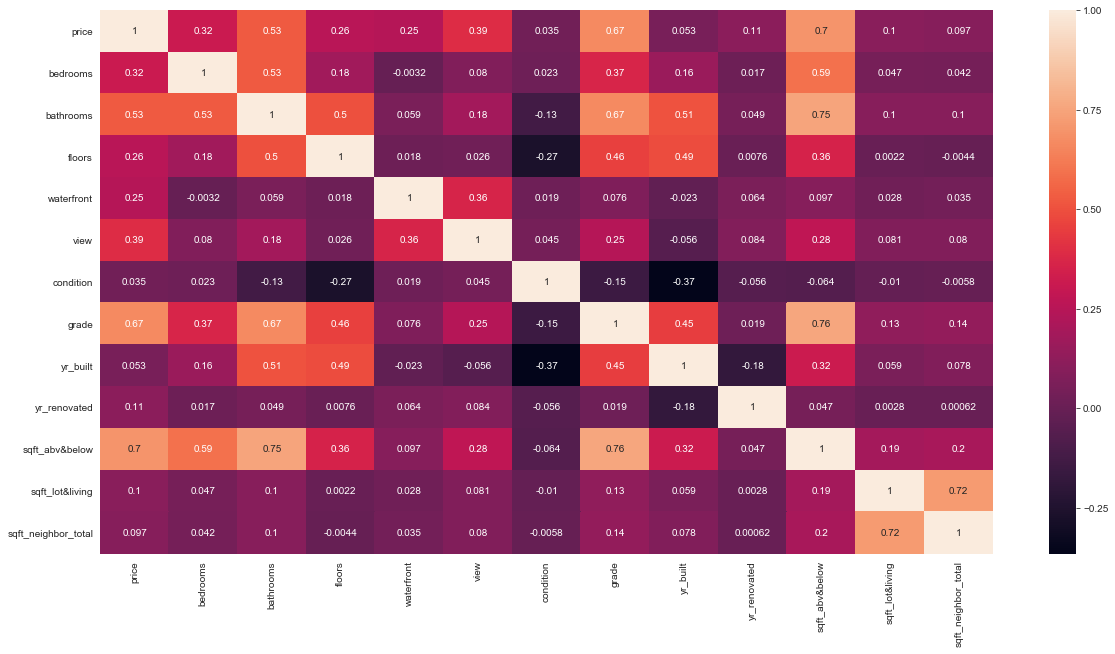

In [14]:
# check for multicollinearity
df_excluding_date_location = df.drop(['date', 'zipcode','lat', 'long'], axis = 1)
correlation_matrix = df_excluding_date_location.corr()

fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(correlation_matrix, annot = True, ax = ax)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


X = df.drop(['price', 'date'], axis =1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1111)
linreg_model = LinearRegression(fit_intercept = False, normalize = True)
linreg_model.fit(X_train, y_train)
predictions = linreg_model.predict(X_test)
mse = mean_squared_error(predictions, y_test)
r_squared = r2_score(predictions, y_test)
coef = np.sort(linreg_model.coef_)

print (r_squared)
print ('\n')
for i in range(len(X.columns)):
    print ('{} coef: {}'.format(X.columns[i], round(coef[i],2)))

0.5550788667691091


bedrooms coef: -184350.56
bathrooms coef: -39887.18
floors coef: -2584.28
waterfront coef: -470.14
view coef: -0.33
condition coef: 0.1
grade coef: 21.16
yr_built coef: 180.36
yr_renovated coef: 14427.26
zipcode coef: 25519.5
lat coef: 40425.69
long coef: 54345.36
sqft_abv&below coef: 104365.1
sqft_lot&living coef: 573299.51
sqft_neighbor_total coef: 587953.95
